# Proyecto 1 Métodos Cuantitativos en Finanazas, USDARS.

**INTEGRANTES**

González Ortega Andrés


## Sección 1: Forwards

### 1. Carga en python la tabla de información de mercado de tasas de interés.

In [ ]:
import pandas as pd

# Cargar el archivo Excel
from google.colab import files

file = files.upload()

# nombrar el archivo que acabamos de subir
archivo = pd.ExcelFile("USDARS.xlsx")

hojas = archivo.sheet_names

hojas

Saving USDARS.xlsx to USDARS.xlsx


['Vol', 'Tasas', 'Superficie']

In [ ]:
# Cargar la hoja "Tasas"
df_tasas = pd.read_excel(archivo, sheet_name="Tasas")

# Mostrar la tabla creada
df_tasas


,Exp,USD Dep,ARS Dep
0,1,0.04414,0.30339
1,7,0.04414,0.30339
2,14,0.04393,0.30340
3,21,0.04387,0.30355
4,30,0.04383,0.30379
5,61,0.04369,0.31848
6,91,0.04342,0.33323
7,124,0.04286,0.34190
8,153,0.04236,0.34797
9,183,0.04187,0.35201


### 2. A partir de esa tabla construye tres vectores. El primer vector que se llame: TasaDom (Tasas domésticas), TasasFor (Tasas foráneas) y PlazoDias.

In [ ]:
#construimos los vectores
TasasFor = df_tasas['USD Dep']
TasaDom = df_tasas['ARS Dep']
PlazoDias = df_tasas['Exp']

print(TasaDom.head())
print(TasasFor.head())
print(PlazoDias.head())


0    0.30339
1    0.30339
2    0.30340
3    0.30355
4    0.30379
Name: ARS Dep, dtype: float64
0    0.04414
1    0.04414
2    0.04393
3    0.04387
4    0.04383
Name: USD Dep, dtype: float64
0     1
1     7
2    14
3    21
4    30
Name: Exp, dtype: int64


### 3. Crea una función que realice interpolación lineal entre tasas de interés interpolacion_tasas(plazo_a_interpolar, vector_plazo_dias, vector_tasas) y que arroje la tsa interpolada para el plazo a interpolar.

$$
r_{int} = r_1 +(\frac{r_2-r_1}{p_2-p_1})(p-p_1)
$$

In [ ]:
import numpy as np

def interpolacion_tasas(plazo_objetivo, plazos, tasas):
    """
    Interpola linealmente una tasa para un plazo objetivo.

    Parámetros:
        plazo_objetivo: int o float - el plazo en días que se quiere interpolar
        plazos: vector de plazos conocidos
        tasas: vector de tasas correspondientes a los plazos

    Retorna:
        tasa interpolada para el plazo objetivo
    """
    plazos = np.array(plazos)
    tasas = np.array(tasas)

    # tomamos los casos donde no es posible interpolar porque se encuentra fuera
    # de la información que tenemos y regresamos el mínimo o el máximo según sea
    # el caso
    if plazo_objetivo <= plazos.min():
        return tasas[plazos.argmin()]
    elif plazo_objetivo >= plazos.max():
        return tasas[plazos.argmax()]
    else:
        # Usamos esta función para encontrar la posición
        # adecuada para interpolar de acuerdo al valor
        # arroja la posición del numero que esta más próximo
        # por encima de nuestra plazo_objetivo
        idx = np.searchsorted(plazos, plazo_objetivo)

        p1, p2 = plazos[idx - 1], plazos[idx]
        r1, r2 = tasas[idx - 1], tasas[idx]
        r_int = r1 + (r2 - r1) / (p2 - p1) * (plazo_objetivo - p1)
        return r_int

In [ ]:
#Ejemplo de uso
itp = 141

interpolacion_dom_141 = interpolacion_tasas(itp, PlazoDias, TasaDom)
interpolacion_for_141 = interpolacion_tasas(itp, PlazoDias, TasasFor)

df_interp = pd.DataFrame({
    "Plazo (días)": [itp],
    "Tasa Doméstica (ARS)": [interpolacion_dom_141],
    "Tasa Foránea (USD)": [interpolacion_for_141]
})

positp = np.searchsorted(PlazoDias, itp)

print(df_interp)
df_tasas.iloc[(positp-1):(positp+1)]

   Plazo (días)  Tasa Doméstica (ARS)  Tasa Foránea (USD)
0           141              0.345458            0.042567


,Exp,USD Dep,ARS Dep
7,124,0.04286,0.34190
8,153,0.04236,0.34797


### 4. Calcula y grafica la curva forward. Supon que la convención que aplica en el mercado es Act/360. Recuerda que:

$$
Fwd_{FOR/DOM}=spot \times exp((r_{dom}-r_{for}) \times \frac{plazo}{360})
$$

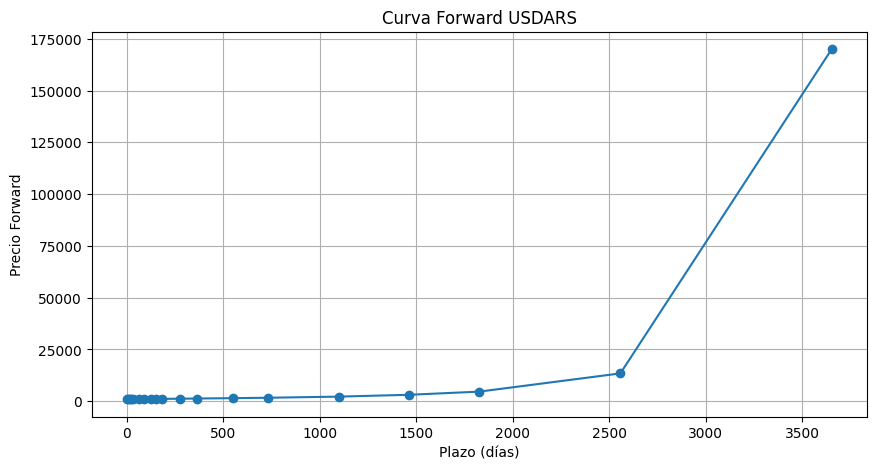

In [ ]:
import matplotlib.pyplot as plt

# Spot USDARS
spot = 985.25

# Crear vectores para la curva forward para graficar después
curva_forward = []

# Para cada plazo, interpolar tasas y calcular forward
for plazo in PlazoDias:
    r_dom = interpolacion_tasas(plazo, PlazoDias, TasaDom)
    r_for = interpolacion_tasas(plazo, PlazoDias, TasasFor)
    fwd = spot * np.exp((r_dom - r_for) * (plazo / 360))
    curva_forward.append(fwd)

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(PlazoDias, curva_forward, marker='o')
plt.title("Curva Forward USDARS")
plt.xlabel("Plazo (días)")
plt.ylabel("Precio Forward")
plt.grid(True)
plt.show()


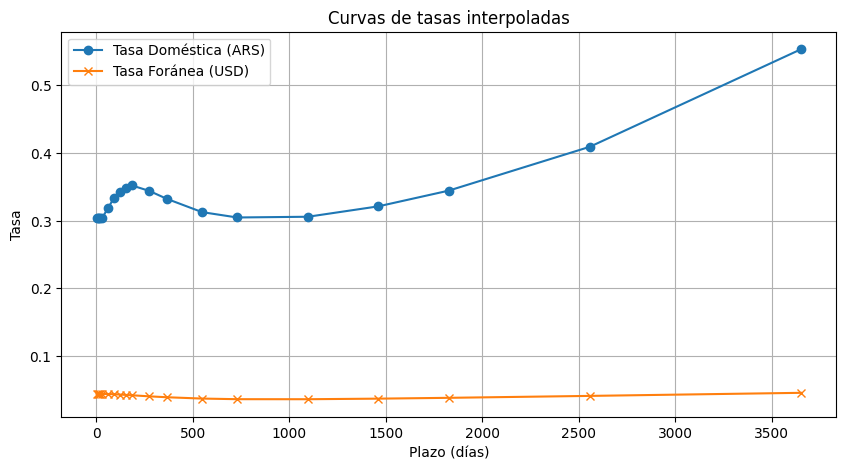

In [ ]:
# Grafiquemos las tasas para comprobar que nuestro resultado anterior es verosimil

TasaDom_interp = [interpolacion_tasas(p, PlazoDias, TasaDom) for p in PlazoDias]
TasasFor_interp = [interpolacion_tasas(p, PlazoDias, TasasFor) for p in PlazoDias]

# Graficar ambas curvas
plt.figure(figsize=(10,5))
plt.plot(PlazoDias, TasaDom_interp, label="Tasa Doméstica (ARS)", marker='o')
plt.plot(PlazoDias, TasasFor_interp, label="Tasa Foránea (USD)", marker='x')
plt.title("Curvas de tasas interpoladas")
plt.xlabel("Plazo (días)")
plt.ylabel("Tasa")
plt.legend()
plt.grid(True)
plt.show()

### 5. Crea una función que realice el cálculo del precio forward y puntos forward dados los isguientes parámetros: valucación_fowards(plazo_dias, tasas_dos, TasasFor, spot). Utiliza la función de interpolación creada en el inciso 3.


In [ ]:
def valuacion_forwards1(plazo_dias, plazos, tasas_dom, tasas_for, spot):
    """
    Calcula el precio forward y puntos forward para un plazo dado.

    Parámetros:
        plazo_dias: int - plazo en días
        plazos: vector de plazos base
        tasas_dom: vector tasas domésticas correspondientes a los plazos
        tasas_for:vector tasas foráneas correspondientes a los plazos
        spot: float - tipo de cambio spot actual

    Retorna:
        (precio_forward, puntos_forward)
    """
    r_dom = interpolacion_tasas(plazo_dias, plazos, tasas_dom)
    r_for = interpolacion_tasas(plazo_dias, plazos, tasas_for)
    fwd = spot * np.exp((r_dom - r_for) * (plazo_dias / 360))
    puntos = (fwd - spot)/10000

    df_resultado = pd.DataFrame({
        "Plazo (días)": [plazo_dias],
        "Tasa Doméstica (ARS)": [r_dom],
        "Tasa Foránea (USD)": [r_for],
        "Spot": spot,
        "Precio Forward": [fwd],
        "Puntos Forward": [puntos]
    })

    return df_resultado

# construimos la función
def valuacion_forwards(plazo_dias, plazos, tasas_dom, tasas_for, spot):
  df = valuacion_forwards1(plazo_dias, plazos, tasas_dom, tasas_for, spot)
  new_df = df[["Precio Forward", "Puntos Forward"]]
  return new_df

# Una forma alternativa de la función enfocada a la legibilidad
#print(valuacion_forwards1(241, PlazoDias, TasaDom, TasasFor, spot),"\n")

# Hacemos un ejemplo con 241 días
valuacion_forwards(241, PlazoDias, TasaDom, TasasFor, spot)

,Precio Forward,Puntos Forward
0,1209.200363,0.022395


### 6. Llega la siguiente cotización a la mesa de trading en el banco en el que trabajas y te piden pasar precio para lo siguiente: Compra de forward de nocional 1,5000,000 USD con liquidación el 18 de septiembre (141 días). Supón que el spread bid/offer del spot es de $\pm 0.0020$. Calcula:



1.   Precio forward
2.   Puntos forward
3.   ¿ Qué panorama crees que tiene el Banco respecto al subyacente al realizar este tipo de transacción? Supón que el Banco se encuentra en el país doméstico. Es decir, si el subyacente es USDARS, el banco es argentino.



In [ ]:
# Ajustar spot por el spread (el cliente (nosotros, el banco argentino) comprará USD → usamos spot offer)
spot_offer = spot + 0.0020
spot_bid = spot - 0.0020

# Calcular forward
val_dias = 141
valuacion_forwards1(val_dias, PlazoDias, TasaDom, TasasFor, spot_offer)





,Plazo (días),Tasa Doméstica (ARS),Tasa Foránea (USD),Spot,Precio Forward,Puntos Forward
0,141,0.345458,0.042567,985.252,1109.350406,0.01241


El panorama para el banco argentino que compra el contrato forward es en parte asegurar que el valor de su dinero; en este caso pesos argentinos, no estará en riesgo de alguna devaluación estrepitosa. Los puntos forward son positivos es decir el valor del subyacente se espera que suba según las expectativas del mercado lo que implica que el peso argentino se devalue frente al dolar. Así nuestro banco protege el valor de su dinero argentino en caso de que la devaluación sea peor de lo que se esperaba. Es decir buscamos estabilidad en una moneda más fuerte que la domestica, pues las tasas foraneas son mucho más bajas.

## Sección 2: Opciones

### 1. Carga en python la tabla de información de mercado de tasas de volatilidades del mercado Fx

In [ ]:
# Cargar la hoja "Vol"
df_vol = pd.read_excel(archivo, sheet_name="Vol")

# Mostrar las primeras filas
df_vol.head()

,Dias,ATM Bid,ATM Ask,35D Call USD Bid,35D Call USD Ask,35D Put USD Bid,35D Put USD Ask,25D Call USD Bid,25D Call USD Ask,25D Put USD Bid,...,15D Put USD Bid,15D Put USD Ask,10D Call USD Bid,10D Call USD Ask,10D Put USD Bid,10D Put USD Ask,5D Call USD Bid,5D Call USD Ask,5D Put USD Bid,5D Put USD Ask
0,1,3.240,14.190,3.593,15.882,1.554,14.551,2.994,18.701,0.000,...,0.000,15.455,0.331,27.939,0.000,15.610,0.000,30.423,0.000,15.788
1,7,5.860,10.420,5.842,10.771,5.654,10.613,5.640,11.480,5.301,...,4.286,12.807,3.759,15.071,3.055,14.555,1.786,18.095,1.050,17.331
2,14,6.615,10.505,6.633,10.820,6.462,10.685,6.530,11.455,6.219,...,5.536,12.584,5.221,14.619,4.555,14.165,3.332,17.656,2.590,17.021
3,21,7.720,10.645,7.785,10.920,7.642,10.813,7.820,11.485,7.557,...,7.282,12.438,7.314,14.126,6.752,13.718,5.825,16.957,5.128,16.465
4,30,8.590,10.770,8.690,11.020,8.564,10.926,8.817,11.533,8.582,...,8.569,12.371,8.857,13.828,8.345,13.440,7.904,16.254,7.245,15.812


### 2. Observa que la tabla de volatilidad tiene las sigueinte columnas: Días, ATM Ask, 35D Call bid, 35D Call Ask, etc. De esta tabal deberás seleccionar ciertas columnas para crear las siguientes dos tablas:



*   VolatilidadBid: Columnas: días, 5DPut Bid, 10DPut Bid, 25DPut Bid, 35DPut Bid, ATM Bid, 35DCall Bid, 25DCallBid, 10DCallBid, 5DCall Bid)

*   VolatilidadAsk: Columnas: Días, 5DPut Ask, 10DPut Ask, 25DPutAsk, 35DPut Bid, ATM ASk, 35DCall Ask, 25DCallBid, 10DCall Ask, 5DCallAsk)



In [ ]:
# Definir columnas requeridas para cada tabla
columnas_bid = [
    "Dias", "5D Put USD Bid", "10D Put USD Bid", "25D Put USD Bid", "35D Put USD Bid",
    "ATM Bid", "35D Call USD Bid", "25D Call USD Bid", "10D Call USD Bid", "5D Call USD Bid"
]

columnas_ask = [
    "Dias", "5D Put USD Ask", "10D Put USD Ask", "25D Put USD Ask", "35D Put USD Ask",
    "ATM Ask", "35D Call USD Ask", "25D Call USD Ask", "10D Call USD Ask", "5D Call USD Ask"
]

# Extraer las subtablas
volatilidad_bid = df_vol[columnas_bid].copy()
volatilidad_ask = df_vol[columnas_ask].copy()

volatilidad_bid.head()


,Dias,5D Put USD Bid,10D Put USD Bid,25D Put USD Bid,35D Put USD Bid,ATM Bid,35D Call USD Bid,25D Call USD Bid,10D Call USD Bid,5D Call USD Bid
0,1,0.000,0.000,0.000,1.554,3.240,3.593,2.994,0.331,0.000
1,7,1.050,3.055,5.301,5.654,5.860,5.842,5.640,3.759,1.786
2,14,2.590,4.555,6.219,6.462,6.615,6.633,6.530,5.221,3.332
3,21,5.128,6.752,7.557,7.642,7.720,7.785,7.820,7.314,5.825
4,30,7.245,8.345,8.582,8.564,8.590,8.690,8.817,8.857,7.904


In [ ]:
volatilidad_ask.head()

,Dias,5D Put USD Ask,10D Put USD Ask,25D Put USD Ask,35D Put USD Ask,ATM Ask,35D Call USD Ask,25D Call USD Ask,10D Call USD Ask,5D Call USD Ask
0,1,15.788,15.610,15.575,14.551,14.190,15.882,18.701,27.939,30.423
1,7,17.331,14.555,11.199,10.613,10.420,10.771,11.480,15.071,18.095
2,14,17.021,14.165,11.206,10.685,10.505,10.820,11.455,14.619,17.656
3,21,16.465,13.718,11.278,10.813,10.645,10.920,11.485,14.126,16.957
4,30,15.812,13.440,11.348,10.926,10.770,11.020,11.533,13.828,16.254


### 3. Transforma las tablas volatilidadBid y VolatilidadAsk del espacio (Tenor, Delta, Vol) al espacio (Tenor, Strike, Vol) mediante la transformación vista en clase. Con $\Delta$ y $\sigma$ dados podemos resolver directamente para el strike K:

$$
K = S_0 exp(-N^{-1}(\Delta)\sigma \sqrt{\tau}+(r_d-r_f+\frac{\sigma^2}{2})\tau)
$$

In [ ]:
from scipy.stats import norm
import numpy as np

def transformar_valores_a_strike(df_vol, plazos_dias, tasas_dom, tasas_for, spot):
    # Mapeo delta por columna
    mapa_delta = {
        "5D Put": 0.05,
        "10D Put": 0.10,
        "25D Put": 0.25,
        "35D Put": 0.35,
        "ATM": 0.50,
        "35D Call": 0.35,
        "25D Call": 0.25,
        "10D Call": 0.10,
        "5D Call": 0.05
    }

    df_resultado = df_vol.copy()

    for col, delta in mapa_delta.items():
        strikes = []
        for i, row in df_vol.iterrows():
            dias = row["Dias"]
            sigma_pct = row[col]
            sigma = sigma_pct / 100
            tau = dias / 360
            r_dom = interpolacion_tasas(dias, plazos_dias, tasas_dom)
            r_for = interpolacion_tasas(dias, plazos_dias, tasas_for)
            if "Call" in col:
                Ninv = -abs(norm.ppf(delta))
            else:
                Ninv = abs(norm.ppf(delta))

            K = spot * np.exp(
                -Ninv * sigma * np.sqrt(tau) +
                (r_dom - r_for + 0.5 * sigma**2) * tau
            )
            strikes.append(K)

        df_resultado[col] = strikes

    return df_resultado

# Estandarizamos los nombres para que sean compatibles con la función
nombres_estandar = [
    "Dias", "5D Put", "10D Put", "25D Put", "35D Put",
    "ATM", "35D Call", "25D Call", "10D Call", "5D Call"
]

# Ahora dependiendo de cual sea nuestro papel en la compra usaremos bid/ask, ambas tienen las mismas columnas pero los valores son diferentes
volatilidad_bid.columns = nombres_estandar
volatilidad_ask.columns = nombres_estandar



# Aplicar a volatilidad_bid
tabla_strikes_bid = transformar_valores_a_strike(volatilidad_bid, PlazoDias , TasaDom, TasasFor, spot_bid)
tabla_strikes_bid.head(11)




,Dias,5D Put,10D Put,25D Put,35D Put,ATM,35D Call,25D Call,10D Call,5D Call
0,1,985.957771,985.957771,985.957771,985.646993,985.959208,986.679229,987.008942,986.178241,985.957771
1,7,987.846291,984.844765,985.329323,987.254169,990.260207,993.373243,995.524645,996.915062,994.294955
2,14,986.926688,983.888511,987.115570,990.445510,995.324656,1000.354385,1004.005149,1008.512429,1006.076575
3,21,980.189660,979.728299,988.211990,993.366609,1000.460042,1007.737669,1013.291173,1023.349148,1023.804963
4,30,972.990302,976.499640,990.444390,997.584010,1007.134219,1016.923802,1024.590270,1040.701449,1045.601353
5,61,956.653391,970.240040,1000.669354,1014.810937,1033.335708,1052.360391,1067.665847,1103.192347,1120.332582
6,91,939.835444,964.759581,1012.737097,1034.400746,1062.698379,1091.949837,1115.916498,1174.631021,1207.914960
7,124,932.085973,966.938032,1030.336005,1058.930246,1096.600121,1136.380465,1170.081634,1257.115876,1311.491094
8,153,929.748535,972.529725,1048.458762,1082.760751,1128.270913,1176.944207,1218.977498,1330.971338,1404.361188
9,183,932.381770,982.172605,1069.455708,1109.042619,1161.879533,1218.912942,1268.848345,1404.849949,1496.848199


In [ ]:
tabla_strikes_ask = transformar_valores_a_strike(volatilidad_ask, PlazoDias , TasaDom, TasasFor, spot_offer)
tabla_strikes_ask.head(11)

,Dias,5D Put,10D Put,25D Put,35D Put,ATM,35D Call,25D Call,10D Call,5D Call
0,1,972.592675,975.653845,980.550905,983.081425,985.989348,989.181627,992.586464,1004.853495,1012.441742
1,7,951.918464,965.005730,979.975278,984.708365,990.335702,996.090890,1001.109180,1017.487567,1032.522531
2,14,942.315690,960.620609,980.759122,987.415392,995.457594,1003.688804,1010.781952,1033.131155,1054.545109
3,21,937.695862,959.232799,982.444672,990.612545,1000.620865,1010.859065,1019.573601,1045.604875,1070.894072
4,30,934.977691,958.713097,985.354859,995.161394,1007.315432,1019.762051,1030.264362,1060.519833,1088.809504
5,61,912.193995,949.468303,994.663351,1012.011395,1033.737757,1056.084222,1074.975507,1128.609879,1176.773731
6,91,893.037543,942.734559,1006.350434,1031.501116,1063.352232,1096.347260,1124.417615,1204.231070,1274.422235
7,124,883.414496,943.855226,1023.649098,1055.977619,1097.522037,1141.449614,1179.772975,1291.089323,1388.771047
8,153,880.082708,948.842288,1041.603040,1079.807885,1129.421622,1182.536618,1229.576940,1368.338535,1490.163014
9,183,881.452418,957.760708,1062.410815,1106.077462,1163.258290,1225.034797,1280.382192,1445.713638,1591.403901


### 4. Calcula el precio de comprar (ask) una opción Call con las siguientes características: vencimiento en 185 días, nocional 100,000 USD y cuyo strike es igual al valor spot. Recuerda que en este caso la opción esta ATM.

In [ ]:
# Versión avanzada: interpolación bidimensional (en delta y plazo)
def interpolar_volatilidad(plazo_dias, tabla_vol, delta_objetivo, tipo="Call"):
    """
    Interpola linealmente la volatilidad para un plazo y delta objetivo
    utilizando doble interpolación (entre deltas y luego en plazo).

    Parámetros:
        plazo_dias: int o float - Plazo en días.
        tabla_vol: DataFrame - Tabla de volatilidades (con columnas tipo "25D Call", "35D Call", etc.).
        delta_objetivo: float - Delta deseada (por ejemplo, 24).
        tipo: str - "Call" o "Put"

    Retorna:
        Volatilidad interpolada en porcentaje.
    """
    # 1. Obtener lista de columnas disponibles para el tipo dado
    columnas_tipo = [col for col in tabla_vol.columns if (tipo in col or col == "ATM")]
    deltas_disponibles = sorted([50 if (col == "ATM") else int(col.split("D")[0]) for col in columnas_tipo])
    # 2. Buscar las deltas adyacentes
    for i in range(1, len(deltas_disponibles)):
        d1 = deltas_disponibles[i-1]
        d2 = deltas_disponibles[i]
        if d1 <= delta_objetivo <= d2:
            col1 = f"{d1}D {tipo}"
            col2 = f"{d2}D {tipo}"
            break
        else:
        # Si está fuera del rango, extrapolamos con los extremos
          if delta_objetivo < deltas_disponibles[0]:
            col1 = col2 = f"{deltas_disponibles[0]}D {tipo}"
            d1 = d2 = deltas_disponibles[0]
          else:
            col1 = col2 = f"{deltas_disponibles[-1]}D {tipo}"
            d1 = d2 = deltas_disponibles[-1]

    # 3. Interpolar en plazo para cada delta disponible
    def interp_en_plazo(col):
        plazos = tabla_vol["Dias"].values
        vols = tabla_vol[col if ("50D" not in col) else "ATM"].values
        if plazo_dias <= plazos[0]:
            return vols[0]
        elif plazo_dias >= plazos[-1]:
            return vols[-1]
        else:
            for i in range(1, len(plazos)):
                if plazo_dias < plazos[i]:
                    p1, p2 = plazos[i-1], plazos[i]
                    v1, v2 = vols[i-1], vols[i]
                    return v1 + (v2 - v1) / (p2 - p1) * (plazo_dias - p1)

    vol1 = interp_en_plazo(col1)
    vol2 = interp_en_plazo(col2)

    # 4. Interpolar entre deltas
    if d1 == d2:
        return vol1
    else:
        return vol1 + (vol2 - vol1) / (d2 - d1) * (delta_objetivo - d1)

# Prueba: delta 24, plazo 30 días (no existe directamente en tabla)
# vol_24d_call_30_bid = interpolar_volatilidad(47, volatilidad_bid, 36)
# vol_24d_call_30_bid


In [ ]:
def precio_call_fx(plazo_dias, delta, tipo_compra,  plazos_tasas = PlazoDias, tasas_dom = TasaDom, tasas_for = TasasFor,nocional = 1):
    """
    Calcula el precio de una opción Call estilo europeo en un mercado FX, usando interpolación de tasas y volatilidades.

    Parámetros:
        plazo_dias: int - plazo en días
        delta: float - delta de la opción (por ejemplo, 24 o 25)
        tipo_compra: str - "Bid" o "Ask"
        plazos_tasas: array-like - plazos conocidos de tasas
        tasas_dom: array-like - tasas domésticas
        tasas_for: array-like - tasas foráneas

    Retorna:
        DataFrame con Precio, Strike y Volatilidad interpolada (%)
    """
    if tipo_compra == "Bid":
      tabla_vol = volatilidad_bid
      spot = spot_bid
    elif tipo_compra == "Ask":
      tabla_vol = volatilidad_ask
      spot = spot_offer
    else:
      raise ValueError("tipo_compra debe ser 'Bid' o 'Ask'")

    r_dom = interpolacion_tasas(plazo_dias, plazos_tasas, tasas_dom)
    r_for = interpolacion_tasas(plazo_dias, plazos_tasas, tasas_for)
    tau = plazo_dias / 360

    sigma_pct = interpolar_volatilidad(plazo_dias, tabla_vol, delta, tipo = "Call")
    sigma = sigma_pct / 100

    Ninv = norm.ppf(delta / 100)
    K = spot * np.exp(
        -Ninv * sigma * np.sqrt(tau) +
        (r_dom - r_for + 0.5 * sigma**2) * tau
    )


    #Usando el modelo Black-Scholes
    d1 = (np.log(spot / K) + (r_dom - r_for + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    call_price = spot * np.exp(-r_for * tau) * norm.cdf(d1) - K * np.exp(-r_dom * tau) * norm.cdf(d2)

    df_resultado = pd.DataFrame({
        "Precio Call": [call_price * nocional],
        "Strike": K,
        "Volatilidad (%)": [sigma_pct]
    })

    df_resultado["Precio Call"] = df_resultado["Precio Call"].apply(lambda x: f"$ {x:,.2f} ARS")
    return df_resultado

# Delta 50 es equivalente a una opción ATM
precio_call_fx(plazo_dias = 185, delta =50,tipo_compra= "Ask", nocional = 100000)

,Precio Call,Strike,Volatilidad (%)
0,"$ 4,646,303.92 ARS",1165.324125,18.245652


### Extra- Calcula el precio de vender (bid) una opción Call con las siguiente características: vencimento en 185 días, nocional de 100,000 USD cuyo strike es igual al valor spot\*(1+10%). En este caso deberás transforma las volatilidades de 185 días del espacio delta al espacio de strikes e interpolar para el valor spot\*(1+10%).

In [ ]:
def precio_call1_fx(plazo_dias, tipo_compra, delta = 50, plazos_tasas = PlazoDias, tasas_dom = TasaDom, tasas_for = TasasFor, nocional = 1):
    """
    Calcula el precio de una opción Call estilo europeo en un mercado FX, usando interpolación de tasas y volatilidades con la condición
    de que el precio spot es 1.1 veces el original.

    Parámetros:
        plazo_dias: int - plazo en días
        delta: float - delta de la opción (por ejemplo, 24 o 25)
        tipo_compra: str - "Bid" o "Ask"
        plazos_tasas: array-like - plazos conocidos de tasas
        tasas_dom: array-like - tasas domésticas
        tasas_for: array-like - tasas foráneas

    Retorna:
        DataFrame con Precio, Strike y Volatilidad interpolada (%)
    """
    if tipo_compra == "Bid":
      tabla_vol = volatilidad_bid
      spot = spot_bid
    elif tipo_compra == "Ask":
      tabla_vol = volatilidad_ask
      spot = spot_offer
    else:
      raise ValueError("tipo_compra debe ser 'Bid' o 'Ask'")


    r_dom = interpolacion_tasas(plazo_dias, plazos_tasas, tasas_dom)
    r_for = interpolacion_tasas(plazo_dias, plazos_tasas, tasas_for)
    tau = plazo_dias / 360

    sigma_pct = interpolar_volatilidad(plazo_dias, tabla_vol, delta, tipo = "Call")
    sigma = sigma_pct / 100

    Ninv = norm.ppf(delta / 100)

    # Redefinimos el precios ATM para el plazo dado es decir el precio spot para dentro de 180 días
    K = spot * np.exp(
        -Ninv * sigma * np.sqrt(tau) +
        (r_dom - r_for + 0.5 * sigma**2) * tau
    )

    # Multiplicamos el precio ATM por 1.1, conseguirmos el spot_futuro*1.1 y con ello conseguimos una opción OTM es decir menos probable que
    # se haga ejercicio de ella y por ello será menor que el precio calculado anteriormente si usaramos el precio spot de hoy por 1.1 sería 1083.5
    # es decir sería menor que el precio ATM en 153 días es decir 1129.421622 por lo tanto esta opción call estaría ITM y con una delta mayor que 50
    # con ello no podríamos interpolar por tanto se recuerre a la descripción que dimos en un principipio para poder evaluar de acuerdo al mercado.
    K = K * 1.1

    # Usamos el modelo Black-Scholes
    d1 = (np.log(spot / K) + (r_dom - r_for + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    call_price = spot * np.exp(-r_for * tau) * norm.cdf(d1) - K * np.exp(-r_dom * tau) * norm.cdf(d2)

    df_resultado = pd.DataFrame({
        "Precio Call": call_price * nocional,
        "Strike": K,
        "Volatilidad (%)": [sigma_pct]
    })

    df_resultado["Precio Call"] = df_resultado["Precio Call"].apply(lambda x: f"$ {x:,.2f} ARS")
    return df_resultado

precio_call1_fx(plazo_dias = 180, tipo_compra = "Bid", nocional = 100000)

,Precio Call,Strike,Volatilidad (%)
0,"$ 1,302,815.36 ARS",1274.268454,16.8291


Ejercio extra antes de interpolar

In [ ]:
#ejercicio extra antes de la modificicación del 19 de mayo

from scipy.interpolate import CubicSpline

# Función que usa interpolación cúbica en ambos ejes: plazo (Días) y delta
def precio_opcion_fx_spline2d(plazo_dias, delta, tipo_compra,
                               plazos_tasas=PlazoDias,
                               tasas_dom=TasaDom,
                               tasas_for=TasasFor,
                               tipo="Put"):
    """
    Calcula el precio de una opción FX (Call o Put) usando interpolación cúbica
    tanto en tenor (tiempo) como en delta (2D spline).

    Parámetros:
        plazo_dias: int - plazo en días
        delta: float - delta objetivo (por ejemplo 24)
        tipo_compra: str - "Bid" o "Ask"
        tipo: str - "Call" o "Put"

    Retorna:
        DataFrame con Precio, Strike y Volatilidad (%)
    """
    if tipo_compra == "Bid":
        tabla_vol = volatilidad_bid
        spot = spot_bid
    elif tipo_compra == "Ask":
        tabla_vol = volatilidad_ask
        spot = spot_offer
    else:
        raise ValueError("tipo_compra debe ser 'Bid' o 'Ask'")

    # Interpolar tasas
    r_dom = interpolacion_tasas(plazo_dias, plazos_tasas, tasas_dom)
    r_for = interpolacion_tasas(plazo_dias, plazos_tasas, tasas_for)
    tau = plazo_dias / 360

    # Extraer deltas y sus columnas
    columnas_tipo = [col for col in tabla_vol.columns if tipo in col and "D" in col]
    deltas_disponibles = sorted([int(col.split("D")[0]) for col in columnas_tipo])
    tabla_deltas = {d: tabla_vol[f"{d}D {tipo}"] for d in deltas_disponibles}

    # Para cada delta, generar spline cúbico en el eje de Días
    spline_en_tiempo = {d: CubicSpline(tabla_vol["Dias"], tabla_deltas[d]) for d in deltas_disponibles}

    # Evaluar en el plazo deseado → obtener vector de (delta, vol)
    delta_vals = np.array(deltas_disponibles)
    vol_vals = np.array([spline_en_tiempo[d](plazo_dias) for d in deltas_disponibles])

    # Spline en eje de delta
    spline_delta = CubicSpline(delta_vals, vol_vals)
    sigma_pct = spline_delta(delta)

    # Valuación BSG
    sigma = sigma_pct / 100
    Ninv = norm.ppf(delta / 100)

    K = spot * np.exp(
        -Ninv * sigma * np.sqrt(tau) +
        (r_dom - r_for + 0.5 * sigma**2) * tau
    )

    d1 = (np.log(spot / K) + (r_dom - r_for + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)

    if tipo == "Call":
        precio = spot * np.exp(-r_for * tau) * norm.cdf(d1) - K * np.exp(-r_dom * tau) * norm.cdf(d2)
    else:
        precio = K * np.exp(-r_dom * tau) * norm.cdf(-d2) - spot * np.exp(-r_for * tau) * norm.cdf(-d1)

    return pd.DataFrame({
        "Precio": [precio],
        "Strike": [K],
        "Volatilidad (%)": [sigma_pct]
    })

# Prueba: opción Put con delta 24 y 30 días, interpolación spline en ambos ejes
precio_opcion_fx_spline2d(30, 24, "Bid", tipo="Put")

,Precio,Strike,Volatilidad (%)
0,21.138009,1025.004268,8.624853466666668


#Fin del documento a 23 de mayo 2025









